In [22]:
# Importing all libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Functions import *

#### Helper Functions

In [23]:
#helper functions
def compute_path_gains(dTU, dSU, dTS, M, c0=1e-3, d0=1, aTU=3.5, aSU=2.0, aTS = 2.0):
    GTU = c0 * (dTU / d0) ** (-aTU)
    
    # Initialize GSU and GTS
    GSU = np.zeros((dSU.shape[0], M))
    GTS = np.zeros((dTS.shape[0], M))
    
    # Compute GSU for each user and each IRS element
    for k in range(dSU.shape[0]):
        for m in range(M):
            GSU[k, m] = c0 * (dSU[k, 0] / d0) ** (-aSU)
    
    # Compute GTS for each IRS face and each element
    for l in range(dTS.shape[0]):
        for m in range(M):
            GTS[l, m] = c0 * (dTS[l, 0] / d0) ** (-aTS)
    
    return GTU, GSU, GTS

def generate_large_scale_fading_new(dTS, dSU, L, K, closest_face_indices):
    numerator = 1
    alpha_kl = np.zeros((K, L))

    if L == 1:
        dTS_l = dTS[0]  # Distance from BS to the single face
        for k in range(K):
            dSU_k = dSU[k]  # Distance from face to user k
            denominator = 1
            alpha_kl[k, 0] = numerator / denominator
    else:
        for k in range(K):
            l = closest_face_indices[k]  # Closest face for user k
            dTS_l = dTS[l]  # Distance from BS to face l
            dSU_k = dSU[k]  # Distance from face l to user k
            denominator = (1 - np.cos(np.pi / L))**2
            alpha_kl[k, l] = numerator / denominator

    return alpha_kl


def compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor):
    hRT = np.zeros(K, dtype=complex)
    hRI = np.zeros((K, M), dtype=complex)
    hIT = np.zeros((L, M), dtype=complex)

    for k in range(K):
        # Compute hRT (channel between BS and users)
        hRT_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
        hRT_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
        hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)

        # Compute hRI (channel between IRS and users)
        for m in range(M):
            hRI_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
            hRI_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
            hRI[k, m] = np.sqrt(GSU[k, m]) * (np.sqrt(K_factor / (1 + K_factor)) * hRI_LoS + np.sqrt(1 / (1 + K_factor)) * hRI_NLoS)

    # Compute hIT (channel between IRS and BS)
    for l in range(L):
        for m in range(M):
            hIT_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
            hIT_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
            hIT[l, m] = np.sqrt(GTS[l, m]) * (np.sqrt(K_factor / (1 + K_factor)) * hIT_LoS + np.sqrt(1 / (1 + K_factor)) * hIT_NLoS)
    
    hRT = hRT.reshape(-1, 1)  # Shape: (K, 1)
    hRI = hRI.transpose()    # Shape: (M, K)
    
    return hRT, hRI, hIT

def compute_SNR_NOMA(link_budget, noise_floor):
    SNR = link_budget - noise_floor
    return dBm2pow(SNR)



In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_user_coordinates(user_pairs, L, base_station=[0, 0, 10], min_distance=1, max_distance=100):
    """
    Generate user coordinates and plot them in L sectors around a base station.

    :param num_pairs: Number of user pairs
    :param L: Number of sectors
    :param base_station: Coordinates of the base station
    :param min_distance: Minimum distance from base station for a_i
    :param max_distance: Maximum distance from base station for b_i
    """
    
    
    # Extract x and y coordinates for plotting
    x_coords = user_pairs[:, 0]
    y_coords = user_pairs[:, 1]
    
    # Plot the base station
    plt.scatter(base_station[0], base_station[1], c='r', marker='x', label='Base Station')
    
    # Plot the user coordinates
    plt.scatter(x_coords, y_coords, c='b', marker='o', label='Users')
    
    # Draw sector boundaries
    angle_increment = 360 / L
    for i in range(L):
        angle = np.deg2rad(i * angle_increment)
        x_boundary = [base_station[0], base_station[0] + max_distance * np.cos(angle)]
        y_boundary = [base_station[1], base_station[1] + max_distance * np.sin(angle)]
        plt.plot(x_boundary, y_boundary, 'k--')
    
    # Set plot limits
    plt.xlim(-max_distance, max_distance)
    plt.ylim(-max_distance, max_distance)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('User Coordinates in Sectors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:



In [38]:
import numpy as np

def generate_user_coordinates(num_pairs, L, base_station=[0, 0, 10], min_distance=1, max_distance=10):
    """
    Generate coordinates for num_pairs of users (a_i, b_i) in L sectors around a base station.

    :param num_pairs: Number of user pairs
    :param L: Number of sectors
    :param base_station: Coordinates of the base station
    :param min_distance: Minimum distance from base station for a_i
    :param max_distance: Maximum distance from base station for b_i
    :return: List of coordinates for user pairs [(a1, b1), (a2, b2), ...]
    """
    base_x, base_y, base_z = base_station
    angle_increment = 360 / L  # Angle increment for each sector
    user_pairs = []

    for i in range(num_pairs):
        sector = i % L  # Determine the sector for the current pair
        angle = np.deg2rad(sector * angle_increment)  # Convert angle to radians

        # Generate coordinates for a_i (close to base station)
        distance_a = np.random.uniform(min_distance, max_distance / 2)
        a_x = (base_x + distance_a * np.cos(angle) ) *10
        a_y = (base_y + distance_a * np.sin(angle) ) * 10
        a_z = 0

        # Generate coordinates for b_i (farther from base station)
        distance_b = np.random.uniform(max_distance / 2, max_distance)
        b_x = (base_x + distance_b * np.cos(angle)) * 10
        b_y = (base_y + distance_b * np.sin(angle) ) * 10
        b_z = 0
        #user_pairs.append([[a_x, a_y, a_z], [b_x, b_y, b_z]])

        #pair = np.array( [ [[a_x, a_y, a_z]] , [[b_x, b_y, b_z]] ] )
        #user_pairs = np.append(user_pairs, pair )
       # user_pairs.append(((a_x, a_y, a_z), (b_x, b_y, b_z)) )
        user_pairs.append([a_x, a_y, a_z] )
        user_pairs.append([b_x, b_y, b_z])
    user_pairs = np.array(user_pairs)
    return user_pairs


#### System parameters

Defining Parameters

    Nt = Number of transmit antennas (SISO = 1)    
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

### Initialize constants

In [26]:

Nt = 1
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 20e6
NF = 10
noise = -174 + 10*np.log10(BW) + NF


#### Network Parameters

In [43]:
def init_network_params(L, BASE_STATION_POSITION,USER_POS):
 #   BASE_STATION_POSITION = (0, 0, 35)
    print("==============NETWORK PARAMETERS BEING INITIATED================")
    dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
    RATE_THRESHOLD = 25
    
    # IRS Position
    IRS_position = (20, 20, 5)
    
    # IRS elements and dimensions
    ####################################################################
    #####                                                       33333333
    ###                                                         33333333
    #3333333333333333333333333333333333333333333333333333333333333333333
    #L = 1 # Number of faces for the IRS (change this for different polygons)
    M = 360 // L
    nIRSrow = M // 6
    nIRScol = M // nIRSrow
    edge_length = 5  # Length of each edge of the IRS in meters
    z_height = edge_length  # Fixed height equal to edge_length
    print("RATE THRESHOLD: ", RATE_THRESHOLD)
    print("IRS position is: ", IRS_position)
    print("Base station position is: ",BASE_STATION_POSITION )
    
    # Assuming previous code parts
    radius = 100  # Range for generation of users within IRS
   # USER_POS = np.array([[30, 30, 1], [50, 50, 1]])
    K = len(USER_POS)
    locU = USER_POS 
    xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
    locT = np.array([BASE_STATION_POSITION])  # Position of BS
    coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)
    dTU, dSU, dTS, closest_face_indices = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position)
    print("Number of users are: ", K, " with a radius of ", radius )
    print("dTU: {}, dSU: {}, dTK: {}, M: {}".format(dTU,dSU,dTS,M))
    return radius, dTU, dSU, dTS,M,K,closest_face_indices

##### Generate variables, circle and fading

In [28]:
def gen_var(L, BASE_STATION_POS, radius,dTU,dSU,dTS, M,K,closest_face_indices,NUM_SIMULATIONS):
    print("===============GENERATING VARIABLES=========================")
    # Generate circle and sectors data for plotting
    x_circle, y_circle, z_circle, sector_lines = generate_circle_and_sectors_3D(BASE_STATION_POS, radius, L)
    # Compute path gains and channels
    
    GTU, GSU, GTS = compute_path_gains(dTU, dSU, dTS, M)
    # Different values of L (number of IRS faces) to simulate

    Pt = np.arange(0, 41, 0.1)  # in dBm
        # Generate large scale fading coefficients once
    alpha_kl = generate_large_scale_fading_new(dTS, dSU, L, K, closest_face_indices)
    # Take the maximum value in each row of alpha_kl to create a matrix of (K, 1)
    alpha_kl_new = np.max(alpha_kl, axis=1).reshape(K, 1)
    G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)
    
    # Variables declared
    outage_probability_disc = np.zeros((NUM_SIMULATIONS, K))
    arr_SNR_disc = np.zeros((NUM_SIMULATIONS, K))
    arr_lb_disc = np.zeros((NUM_SIMULATIONS, K))
    average_SNR_1 = []
    
    # Initialize arrays to store results for each L value
    h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
    h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
    h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
        # Perform simulations
    for i in range(NUM_SIMULATIONS):
        print("Simulation: ", i)
        
        # Compute channels
        hTU, hSU, hTS = compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor=10)
    
        # Store results for each simulation
        h_dk_3d[i] = hTU  # BS to users
        h_rk1_3d[i] = hSU  # IRS to users
        h_rk1_h_3d[i] = np.conj(np.transpose(hSU))  # Transpose IRS to users
        G1_3d[i] = hTS  # BS to all IRS faces and their elements
        #print("Gain from BS to all IRS faces an elements", G1_3d[i])
        
    print("===================RUNNING SIMULATION===========================")
    for T in Pt: # Converting the dBm power to watts for further use
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        # Initialize sum-rates for this case
        SNR = []
        print("===========================For Power of : ", T," ==================================")
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            print("Simulation number: ", s)
            h_dk = h_dk_3d[s]  # Shape: (K, 1)
            h_rk = h_rk1_3d[s]  # Shape: (M, K)
            h_rk_transpose = h_rk1_h_3d[s]  # Shape: (K, M)
            G = G1_3d[s]  # Shape: (L, M)
         #   print("G is")
          #  print(np.info(G))
           # print("G1_3d is")
            #print(np.info(G1_3d)) '''
            
            # Compute theta and product matrix
            theta = theta_matrix_ideal(1, h_dk, h_rk, G, K, M, L)
            results_array = prod_matrix(theta, h_rk_transpose, G, K, M, L, closest_face_indices)
            
            # Calculate sum rate
            arr_link_budget = np.abs((TRANSMIT_POWER_WATTS * alpha_kl_new)**0.5 * (h_dk + results_array))
            arr_link_budget = pow2dBm((arr_link_budget)**2)
            arr_SNR_disc[s, :] = compute_SNR_NOMA(arr_link_budget, noise).flatten()
            SNR.append(arr_SNR_disc[s])
            print("arr_link_budget: ", arr_link_budget)
        # Calculate average sum rate across simulations for this Pt
        average_SNR_1.append(np.mean(SNR, axis=0))
        #print("AVERAGE SNR: ", average_SNR_1)
    
    # Convert list to numpy array
    average_SNR_1 = np.array(average_SNR_1)
    average_SNR_1 = average_SNR_1.reshape(K, len(Pt))
    
    print(np.shape(average_SNR_1))
    
    #Compute mean SNR for each row
    mean_SNR = (np.mean(average_SNR_1, axis=1))

    return mean_SNR, average_SNR_1, Pt

### Calculate rates from mean and avg snr

In [29]:

def calc_rates(mean_SNR, average_SNR_1):
    print("Calculating R1,R2 values from mean SNR")
    # Determine which row corresponds to SNR1 and SNR2 based on mean SNR
    if mean_SNR[0] > mean_SNR[1]:
        SNR1 = average_SNR_1[0, :]
        SNR2 = average_SNR_1[1, :]
    else:
        SNR1 = average_SNR_1[1, :]
        SNR2 = average_SNR_1[0, :]
    
    a = 0.3  # Power allocation coefficient for user 1
    
    # Compute rates
    R2 = np.log2(1 + (1-a) * SNR2 / (a * SNR2 + 1))
    R1 = np.log2(1 + a * SNR1)
    
    print(np.shape(R1))
    print(np.shape(R2))
    return R1,R2

### Graph stuff

In [30]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def graph(R1,R2,Pt):
    window_size = 10  # Window size for moving average
    
    # Apply moving average for smoothing
    R1 = moving_average(R1, window_size)
    R2 = moving_average(R2, window_size)
    
    # Plotting
    plt.plot(Pt, R1, label='R1 (User 1)')
    plt.plot(Pt, R2, label='R2 (User 2)')
    plt.xlabel('Transmit Power (dBm)')
    plt.ylabel('Rate (bps/Hz)')
    plt.title('Rate vs. Transmit Power')
    plt.xlim(0,40)
    plt.legend()
    plt.grid(True)
    plt.show()

### main function wrapping it all together

In [31]:
def BDIRS_NOMA_PERFORMANCE(L,NUM_SIMULATIONS,noise,BASE_STATION_POSITION,USER_POS):
   # Nt,f,c,Lambda,halfLambda,quarterLambda,BW,NF,noise = init_constants()
    radius, dTU, dSU, dTS,M,K,closest_face_indices = init_network_params(L,BASE_STATION_POSITION,USER_POS )
    mean_snr,average_SNR_1,Pt =  gen_var(L, BASE_STATION_POSITION, radius,dTU,dSU,dTS, M,K,closest_face_indices,NUM_SIMULATIONS)
    r1,r2 = calc_rates(mean_snr,average_SNR_1)
    graph(r1,r2,Pt)

In [32]:

bs_pos = (0, 0, 35)


In [33]:
#BDIRS_NOMA_PERFORMANCE(5, 50, noise, bs_pos,users_pos)

In [34]:
#BDIRS_NOMA_PERFORMANCE(2, num_sim, noise, bs_pos,users_pos)

In [ ]:
#BDIRS_NOMA_PERFORMANCE(3, num_sim, noise, bs_pos,users_pos)

In [ ]:
#BDIRS_NOMA_PERFORMANCE(5, num_sim, noise, bs_pos,users_pos)

##### Observations
increasing L increases R1 rate as well as R2 but not as much

In [ ]:
#BDIRS_NOMA_PERFORMANCE(8, num_sim, noise, bs_pos,users_pos)

In [ ]:
users = np.array([[30, 30, 1], [50, 50, 1], [0, 40,1] ] )
#BDIRS_NOMA_PERFORMANCE(5, 50, noise, bs_pos,users)

## Generate user pairs for noma scenario depending upon L and number of pairs

In [ ]:
print("first level, : ", type(users_pos) )
print("info " , np.info(users_pos))
print("2n level, : ", type(users_pos[0]))
print("3rd level, : ", type(users_pos[0][0]))
print(users_pos)
print(users_pos[0])

In [ ]:

# Example usage
num_pairs = 3
L = 3
user_coordinates = generate_user_coordinates(num_pairs, L)
print("first level, : ", type(user_coordinates))
print("info " , np.info(user_coordinates))
print("2n level, : ", type(user_coordinates[0]))
print("info " , np.info(user_coordinates[0]))
#print("3rd level, : ", type(user_coordinates[0][0]))
#print(user_coordinates)
print(user_coordinates)
print(user_coordinates[0])
#for i, (a, b) in enumerate(user_coordinates, 1):
 #   print(f"Pair {i}: a_i={a}, b_i={b}")


In [39]:
users = generate_user_coordinates(3, 3)

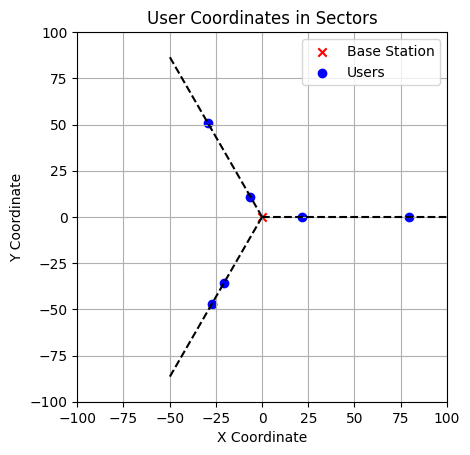

In [42]:
plot_user_coordinates(user_pairs=users, L=3)

==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (20, 20, 5)
Base station position is:  (0, 0, 35)
Number of users are:  6  with a radius of  100
dTU: [[41.03524199]
 [87.01324877]
 [37.1896216 ]
 [68.58071747]
 [54.20781455]
 [64.80842818]], dSU: [[19.41784173]
 [62.05419862]
 [26.92944704]
 [57.4373579 ]
 [68.44643136]
 [81.52382439]], dTK: [[42.20131333]
 [40.55056481]
 [40.99940057]], M: 120
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
Simulation:  10
Simulation:  11
Simulation:  12
Simulation:  13
Simulation:  14
Simulation:  15
Simulation:  16
Simulation:  17
Simulation:  18


C:\Users\DNS\AppData\Local\Temp\ipykernel_6676\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


Simulation:  19
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-82.72531746]
 [-89.79237732]
 [-78.97149042]
 [-89.56011247]
 [-83.12702386]
 [-86.90165074]]
Simulation number:  1
arr_link_budget:  [[ -81.09729933]
 [-102.20276172]
 [ -79.48867883]
 [ -89.07244151]
 [ -83.73424691]
 [ -88.6206554 ]]
Simulation number:  2
arr_link_budget:  [[-76.70709177]
 [-91.85820826]
 [-79.31244294]
 [-87.88612664]
 [-87.60929759]
 [-87.82390055]]
Simulation number:  3
arr_link_budget:  [[-78.69783421]
 [-91.58357255]
 [-81.80151542]
 [-88.27554213]
 [-84.91606637]
 [-89.05909191]]
Simulation number:  4
arr_link_budget:  [[-77.49450542]
 [-93.41689519]
 [-83.58871648]
 [-86.89273216]
 [-85.50066997]
 [-85.33150991]]
Simulation number:  5
arr_link_budget:  [[-81.26964789]
 [-92.99729733]
 [-78.34232243]
 [-91.47104094]
 [-83.55122841]
 [-91.24727443]]
Simulati

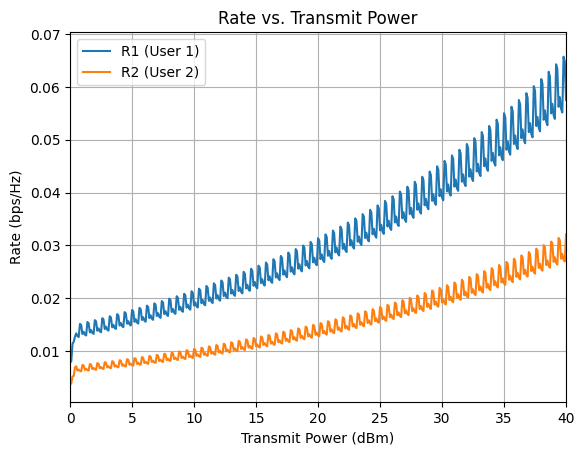

In [44]:
BDIRS_NOMA_PERFORMANCE(3, 20, noise, bs_pos,users)

In [45]:
users_four = generate_user_coordinates(4, 4)

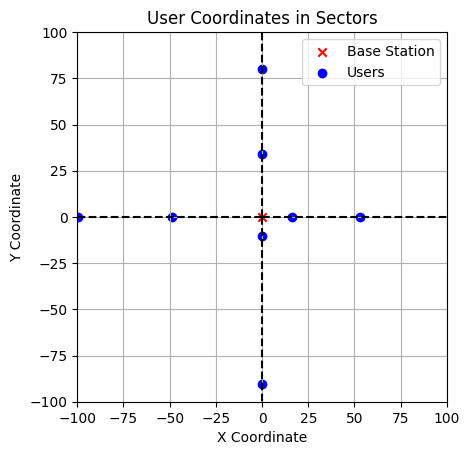

In [46]:
plot_user_coordinates(user_pairs=users_four, L=4)

==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (20, 20, 5)
Base station position is:  (0, 0, 35)
Number of users are:  8  with a radius of  100
dTU: [[ 38.51291386]
 [ 63.5137342 ]
 [ 48.94050471]
 [ 87.51487852]
 [ 60.03069788]
 [105.59124133]
 [ 36.51998727]
 [ 97.14460598]], dSU: [[ 19.02865268]
 [ 36.50840207]
 [ 22.63114079]
 [ 61.42525405]
 [ 69.62003709]
 [119.36078065]
 [ 34.33264653]
 [110.48226624]], dTK: [[42.98454788]
 [41.3067791 ]
 [39.55791506]
 [41.3067791 ]], M: 90
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
Simulation:  10
Simulation:  11
Simulation:  12
Simulation:  13
Simulation:  14


C:\Users\DNS\AppData\Local\Temp\ipykernel_6676\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


Simulation:  15
Simulation:  16
Simulation:  17
Simulation:  18
Simulation:  19
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-72.88153612]
 [-84.10881967]
 [-76.66645838]
 [-90.8039378 ]
 [-79.58274993]
 [-91.15040274]
 [-72.62011091]
 [-89.59753223]]
Simulation number:  1
arr_link_budget:  [[-74.9140679 ]
 [-83.02615739]
 [-78.97097383]
 [-85.91309626]
 [-81.75673325]
 [-89.23985929]
 [-74.96050458]
 [-91.97954135]]
Simulation number:  2
arr_link_budget:  [[-72.7102058 ]
 [-84.01930516]
 [-79.12377154]
 [-84.84383409]
 [-82.35129839]
 [-90.45852125]
 [-74.64025169]
 [-87.82236384]]
Simulation number:  3
arr_link_budget:  [[-77.80337348]
 [-78.54068888]
 [-74.28823472]
 [-89.69636786]
 [-85.47842435]
 [-95.68457515]
 [-74.07997899]
 [-89.06282225]]
Simulation number:  4
arr_link_budget:  [[-72.65342747]
 [-81.1020274 ]
 [-75.04721861]
 [-87.55

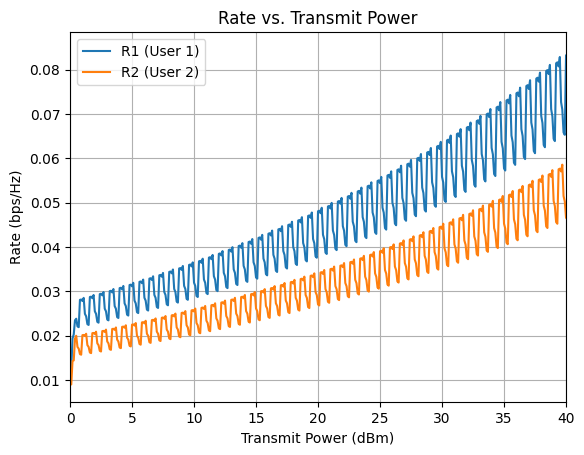

In [47]:
BDIRS_NOMA_PERFORMANCE(4, 20, noise, bs_pos,users_four)